In diesem Notebook werden Bilder mit den assoziierten Sensordaten dargestellt.

In [1]:
import pandas
import seaborn as sns
%matplotlib inline 
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from scipy.interpolate import interp1d
import numpy as np

In [2]:
# Lesen der Merkmale
featuresDf = pandas.read_csv("merkmale.csv")
featuresDf.describe()

,Zeitstempel,Breitengrad,Laengengrad,Geschwindigkeit,Messwerte,StartBewegungsD,StartBelichtung,Belichtungszeit,MittelX,MittelY,...,VarianzX,VarianzY,VarianzZ,VarianzNick,VarianzRoll,AbweichungX,AbweichungY,AbweichungZ,AbweichungNick,AbweichungRoll
count,4.033000e+03,4033.000000,4033.000000,4033.000000,4033.0,4.033000e+03,4.033000e+03,4.033000e+03,4033.000000,4033.000000,...,4033.000000,4033.000000,4033.000000,4033.000000,4033.000000,4033.000000,4033.000000,4033.000000,4033.000000,4033.000000
mean,1.520432e+12,53.614175,10.163583,13.797908,10.0,2.767638e+14,2.767639e+14,2.457690e+07,0.003357,0.005873,...,1.775910,11.933649,14.219520,0.149713,0.257838,1.054825,2.679763,2.940742,0.328067,0.291006
std,3.118401e+05,0.001194,0.014844,5.423002,0.0,3.118390e+11,3.118374e+11,5.764559e+06,0.463115,0.983133,...,4.195735,26.817699,29.858675,0.174804,0.742549,0.814505,2.180297,2.360708,0.205171,0.416169
min,1.520432e+12,53.610508,10.137785,0.000000,10.0,2.762160e+14,2.762161e+14,8.963045e+06,-3.123777,-8.407249,...,0.000100,0.000050,0.000140,0.000000,0.000000,0.010000,0.007070,0.011830,0.000000,0.000000
25%,1.520432e+12,53.613804,10.151080,11.520000,10.0,2.765011e+14,2.765012e+14,2.000368e+07,-0.224284,-0.415963,...,0.345590,2.103500,2.373990,0.033290,0.006390,0.587870,1.450340,1.540780,0.182460,0.079940
50%,1.520432e+12,53.614390,10.161076,15.264000,10.0,2.767615e+14,2.767615e+14,2.000368e+07,0.002862,0.004920,...,0.786830,4.865580,5.798350,0.085230,0.018030,0.887030,2.205810,2.407980,0.291940,0.134280
75%,1.520432e+12,53.615047,10.179163,17.352000,10.0,2.770310e+14,2.770311e+14,2.999632e+07,0.226910,0.422276,...,1.723130,10.606310,13.304090,0.196760,0.069060,1.312680,3.256730,3.647480,0.443580,0.262790
max,1.520433e+12,53.615852,10.185279,23.544000,10.0,2.773140e+14,2.773141e+14,2.999632e+07,4.367661,9.612721,...,111.032600,504.585710,403.466180,1.497310,8.279670,10.537200,22.462990,20.086470,1.223650,2.877440


In [3]:
featuresDf.columns

Index(['Zeitstempel', 'Breitengrad', 'Laengengrad', 'Geschwindigkeit',
       'AccelerometerX', 'AccelerometerY', 'AccelerometerZ', 'Azimuth', 'Nick',
       'Roll', 'SensorZeitstempel', 'Messwerte', 'StartBewegungsD',
       'StartBelichtung', 'Belichtungszeit', 'MittelX', 'MittelY', 'MittelZ',
       'MittelNick', 'MittelRoll', 'AzimuthAenderung', 'VarianzX', 'VarianzY',
       'VarianzZ', 'VarianzNick', 'VarianzRoll', 'AbweichungX', 'AbweichungY',
       'AbweichungZ', 'AbweichungNick', 'AbweichungRoll'],
      dtype='object')

In [5]:
sensorTimestampsDf = pandas.DataFrame(np.array(featuresDf.SensorZeitstempel.str.split(" ").tolist()).astype(float))
accX = pandas.DataFrame(np.array(featuresDf.AccelerometerX.str.split(" ").tolist()).astype(float))
accY = pandas.DataFrame(np.array(featuresDf.AccelerometerY.str.split(" ").tolist()).astype(float))
accZ = pandas.DataFrame(np.array(featuresDf.AccelerometerZ.str.split(" ").tolist()).astype(float))
nick = pandas.DataFrame(np.array(featuresDf.Nick.str.split(" ").tolist()).astype(float))
roll = pandas.DataFrame(np.array(featuresDf.Roll.str.split(" ").tolist()).astype(float))
azimuth = pandas.DataFrame(np.array(featuresDf.Azimuth.str.split(" ").tolist()).astype(float))

In [38]:
row = 2500 # TODO änderung Zugriff mit Hilde eines Zeitstempels?
timestampsMinMax = [sensorTimestampsDf.iloc[row,0],sensorTimestampsDf.iloc[row,-1]]
featuresDf.Zeitstempel[row]

1520432248179

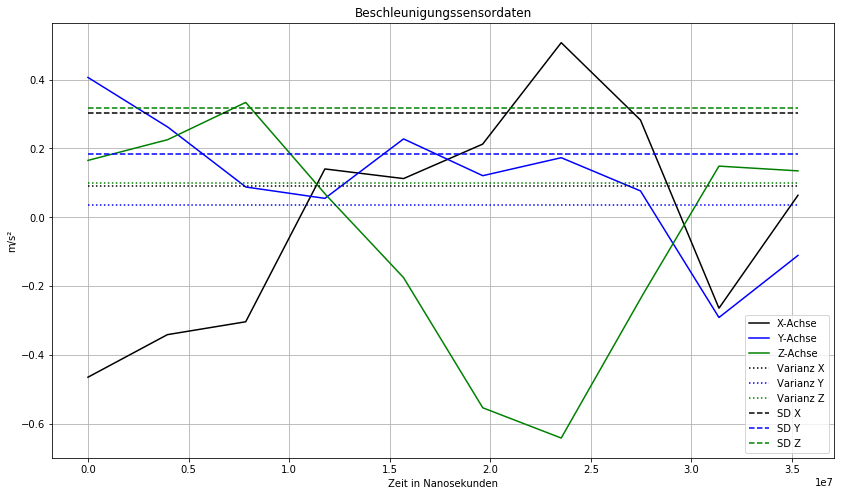

In [39]:
plt.figure(figsize=(14,8))
fAccX = interp1d(np.asarray(sensorTimestampsDf.iloc[[row]]).squeeze(),np.asarray(accX.iloc[[row]]).squeeze())
fAccY = interp1d(np.asarray(sensorTimestampsDf.iloc[[row]]).squeeze(),np.asarray(accY.iloc[[row]]).squeeze())
fAccZ = interp1d(np.asarray(sensorTimestampsDf.iloc[[row]]).squeeze(),np.asarray(accZ.iloc[[row]]).squeeze())
xnew = np.arange(sensorTimestampsDf.iloc[row,0],sensorTimestampsDf.iloc[row,-1],10000)
plt.plot(xnew,fAccX(xnew),'k-',xnew,fAccY(xnew),'b-',xnew,fAccZ(xnew),'g-',
        timestampsMinMax,[featuresDf.VarianzX.iloc[row],featuresDf.VarianzX.iloc[row]], 'k:',
        timestampsMinMax,[featuresDf.VarianzY.iloc[row],featuresDf.VarianzY.iloc[row]], 'b:',
        timestampsMinMax,[featuresDf.VarianzZ.iloc[row],featuresDf.VarianzZ.iloc[row]], 'g:',
        timestampsMinMax,[featuresDf.AbweichungX.iloc[row],featuresDf.AbweichungX.iloc[row]], 'k--',
        timestampsMinMax,[featuresDf.AbweichungY.iloc[row],featuresDf.AbweichungY.iloc[row]], 'b--',
        timestampsMinMax,[featuresDf.AbweichungZ.iloc[row],featuresDf.AbweichungZ.iloc[row]], 'g--')
xLine = mlines.Line2D([], [], color='black', linestyle='-', label='X-Achse')
yLine = mlines.Line2D([], [], color='blue', linestyle='-', label='Y-Achse')
zLine = mlines.Line2D([], [], color='green', linestyle='-', label='Z-Achse')
vXline = mlines.Line2D([], [], color='black', linestyle=':', label='Varianz X')
vYline = mlines.Line2D([], [], color='blue', linestyle=':', label='Varianz Y')
vZline = mlines.Line2D([], [], color='green', linestyle=':', label='Varianz Z')
dXline = mlines.Line2D([], [], color='black', linestyle='--', label='SD X')
dYline = mlines.Line2D([], [], color='blue',linestyle='--', label='SD Y')
dZline = mlines.Line2D([], [], color='green', linestyle='--', label='SD Z')
plt.legend(handles=[xLine,yLine,zLine,vXline,vYline,vZline,dXline,dYline,dZline], loc='lower right', framealpha=0.8)
plt.title('Beschleunigungssensordaten')
plt.xlabel('Zeit in Nanosekunden')
plt.ylabel('m/s²')
plt.grid()

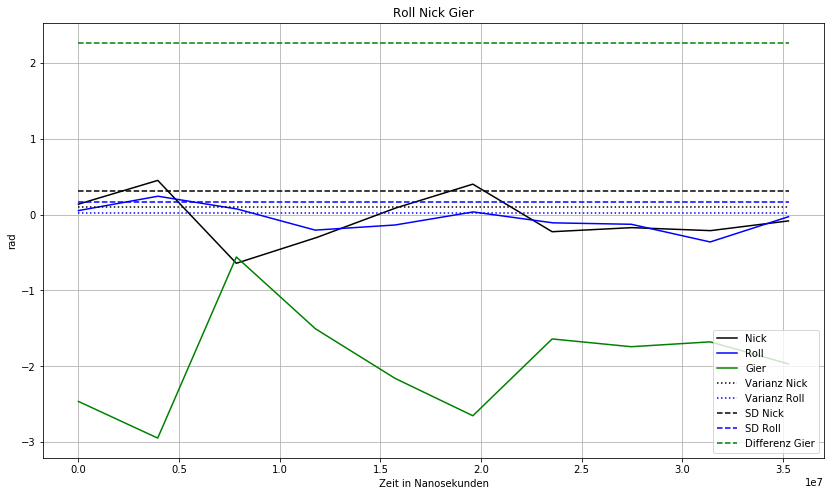

In [29]:
plt.figure(figsize=(14,8))
fNick = interp1d(np.asarray(sensorTimestampsDf.iloc[[row]]).squeeze(),np.asarray(nick.iloc[[row]]).squeeze())
fRoll = interp1d(np.asarray(sensorTimestampsDf.iloc[[row]]).squeeze(),np.asarray(roll.iloc[[row]]).squeeze())
fAzimuth = interp1d(np.asarray(sensorTimestampsDf.iloc[[row]]).squeeze(),np.asarray(azimuth.iloc[[row]]).squeeze())
plt.plot(xnew,fNick(xnew),'k-',xnew,fRoll(xnew),'b-',xnew,fAzimuth(xnew),'g-',
        timestampsMinMax,[featuresDf.VarianzNick.iloc[row],featuresDf.VarianzNick.iloc[row]], 'k:',
        timestampsMinMax,[featuresDf.VarianzRoll.iloc[row],featuresDf.VarianzRoll.iloc[row]], 'b:',
        timestampsMinMax,[featuresDf.AbweichungNick.iloc[row],featuresDf.AbweichungNick.iloc[row]], 'k--',
        timestampsMinMax,[featuresDf.AbweichungRoll.iloc[row],featuresDf.AbweichungRoll.iloc[row]], 'b--',
        timestampsMinMax,[featuresDf.AzimuthAenderung.iloc[row],featuresDf.AzimuthAenderung.iloc[row]], 'g--')
pLine = mlines.Line2D([], [], color='black', linestyle='-', label='Nick')
rLine = mlines.Line2D([], [], color='blue', linestyle='-', label='Roll')
aLine = mlines.Line2D([], [], color='green', linestyle='-', label='Gier')
vPline = mlines.Line2D([], [], color='black', linestyle=':', label='Varianz Nick')
vRline = mlines.Line2D([], [], color='blue', linestyle=':', label='Varianz Roll')
dPline = mlines.Line2D([], [], color='black', linestyle='--', label='SD Nick')
dRline = mlines.Line2D([], [], color='blue', linestyle='--', label='SD Roll')
aCline = mlines.Line2D([], [], color='green', linestyle='--', label='Differenz Gier')
plt.legend(handles=[pLine,rLine,aLine,vPline,vRline,dPline,dRline,aCline],loc='lower right', framealpha=0.8)
plt.title('Roll Nick Gier')
plt.xlabel('Zeit in Nanosekunden')
plt.ylabel('rad')
plt.grid()

In [ ]:
plt.figure(figsize=(7,7))
fNick = interp1d(np.asarray(sensorTimestampsDf.iloc[[row]]).squeeze(),np.asarray(nick.iloc[[row]]).squeeze())
fRoll = interp1d(np.asarray(sensorTimestampsDf.iloc[[row]]).squeeze(),np.asarray(roll.iloc[[row]]).squeeze())
fAzimuth = interp1d(np.asarray(sensorTimestampsDf.iloc[[row]]).squeeze(),np.asarray(azimuth.iloc[[row]]).squeeze())
plt.plot(sensorTimestampsDf.iloc[[row]],nick.iloc[[row]],'ko',xnew,fNick(xnew),'k-',
        sensorTimestampsDf.iloc[[row]],roll.iloc[[row]],'bo',xnew,fRoll(xnew),'b-',
        sensorTimestampsDf.iloc[[row]],azimuth.iloc[[row]],'go',xnew,fAzimuth(xnew),'g-')
nick_line = mlines.Line2D([], [], color='black', marker='o',
                          markersize=10, label='Nick')
roll_line = mlines.Line2D([], [], color='blue', marker='o',
                          markersize=10, label='Roll')
azimuth_line = mlines.Line2D([], [], color='green', marker='o',
                          markersize=10, label='Gier')
plt.legend(handles=[nick_line,roll_line,azimuth_line])
plt.title('Roll Nick Gier')
plt.xlabel('Zeit in Nanosekunden')
plt.ylabel('rad')
plt.grid()